In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score 
from sklearn import svm
from sklearn.model_selection import GridSearchCV

## Read CSV, Preprocessing Data

In [39]:
pathology = pd.read_csv('pathology_results.csv')
normal = pd.read_csv('norm_results.csv')

#избавление от сэмплов со звуком "и"
pathology.drop(pathology[pathology['voiceID'].str.contains('a') == False].index,inplace=True)
normal.drop(normal[normal['voiceID'].str.contains('a') == False].index,inplace = True)

#избавление от мужских сэмплов
pathology.drop(pathology[pathology['voiceID'].str.contains('m') == True].index, inplace=True)
normal.drop(normal[normal['voiceID'].str.contains('m') == True].index, inplace=True)

## Class Equalling

In [40]:
pathology = pathology.iloc[:,1:]

# увеличение патологической выборки в два раза
pathology = pd.concat([pathology, pathology])
pathology['label'] = 'p'

normal = normal.iloc[:,1:]
normal['label'] = 'h'


print('Normal voices samples:',normal.shape)
print('Pathological voices samples:',pathology.shape)

Normal voices samples: (276, 8)
Pathological voices samples: (256, 8)


In [34]:
pathology.head()

,meanF0Hz,stdevF0Hz,HNR,localJitter,ppq5Jitter,localShimmer,apq11Shimmer,label
0,273.066032,8.137112,4.923343,0.033614,0.020712,0.111561,0.097909,p
2,260.920623,6.093177,3.650458,0.043765,0.028389,0.103721,0.091496,p
3,248.684460,1.323849,20.433904,0.003035,0.001855,0.005271,0.004229,p
5,215.480959,1.535190,18.137807,0.004929,0.002612,0.055351,0.046380,p
6,273.437766,18.424732,12.616350,0.006140,0.003541,0.111213,0.077804,p


## All Voices Summarization

In [41]:
voices = pd.concat([normal,pathology])

In [42]:
X = voices.iloc[:,:-1]
y = voices.iloc[:,-1]
print("All voice samples", X.shape)

All voice samples (532, 7)


## Statistics and Scaling

In [66]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3, shuffle=True,
                                                    stratify=y)
print("Pathology train:", y_train[y_train.str.contains('p')==True].shape[0])
print("Normal train:", y_train[y_train.str.contains('p')==False].shape[0])
print("Pathology test:", y_test[y_test.str.contains('p')==True].shape[0])
print("Normal test:", y_test[y_test.str.contains('p')==False].shape[0])


scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print("Min значение признака после масштабирования:", X_test_scaled.min(axis=0))
print("Max значение признака после масштабирования:", X_test_scaled.max(axis=0))
scaler.fit(X)
X_scaled = scaler.transform(X)

Pathology train: 179
Normal train: 193
Pathology test: 77
Normal test: 83
Min значение признака после масштабирования: [0. 0. 0. 0. 0. 0. 0.]
Max значение признака после масштабирования: [1. 1. 1. 1. 1. 1. 1.]


# Support Vector Machine

In [67]:
parameters = {'kernel':['rbf','linear'], 'C':[0.1,1.0,5.0,10.0,50.0,100.0], 'gamma':[1,3,5,10,50,100,150]}
svc = svm.SVC(probability=True)

clf = GridSearchCV(svc,parameters,cv=5)
clf.fit(X_train_scaled, y_train)
print("Best score:", clf.best_score_)
print("Best parameters:", clf.best_params_)

clf = clf.best_estimator_
print('\n',classification_report(y_test, clf.predict(X_test_scaled), target_names=['health', 'pathology']))
print("Accuracy on test:",accuracy_score(y_test, clf.predict(X_test_scaled)))

Best score: 0.7768817204301075
Best parameters: {'C': 100.0, 'gamma': 150, 'kernel': 'rbf'}

               precision    recall  f1-score   support

      health       0.86      0.67      0.76        83
   pathology       0.72      0.88      0.79        77

   micro avg       0.78      0.78      0.78       160
   macro avg       0.79      0.78      0.77       160
weighted avg       0.79      0.78      0.77       160

Accuracy on test: 0.775


/home/silenos/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0.83333333 0.83333333 0.75925926 0.92592593 0.7962963  0.87037037
 0.98076923 0.82692308 0.76923077 0.84615385]


Text(0.5, 1.0, 'Average score: 0.8441595441595441')

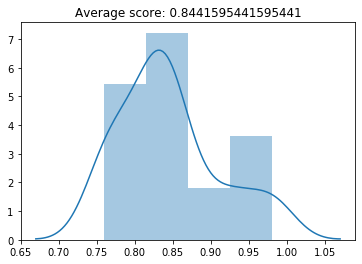

In [68]:
cv_scores = cross_val_score(clf, X_scaled, y, cv=10)
print(cv_scores)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

# GradientBoostingClassifier

Best score: 0.8225806451612904
Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 34}

               precision    recall  f1-score   support

      health       0.92      0.86      0.89        83
   pathology       0.86      0.92      0.89        77

   micro avg       0.89      0.89      0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160

Accuracy test score: 0.8875


/home/silenos/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


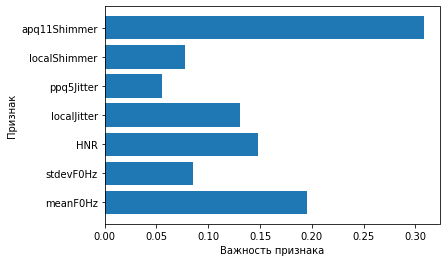

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state = 12)
params = {'learning_rate':[0.1,0.2,0.3, 0.4, 0.5],'n_estimators':[4,8,12,24,34,50], 'max_depth':[1,2,3,4,5]}
clf = GridSearchCV(GB,params,cv=10)
clf.fit(X_train, y_train)
print("Best score:", clf.best_score_)
print("Best parameters:", clf.best_params_)
clf = clf.best_estimator_

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.iloc[:])
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
    
plot_feature_importances(clf)
print('\n',classification_report(y_test,clf.predict(X_test), target_names=['health', 'pathology']))
print('Accuracy test score:', accuracy_score(y_test,clf.predict(X_test)))

[0.90740741 0.85185185 0.87037037 0.85185185 0.77777778 0.90740741
 0.92307692 0.84615385 0.78846154 0.88461538]


Text(0.5, 1.0, 'Average score: 0.860897435897436')

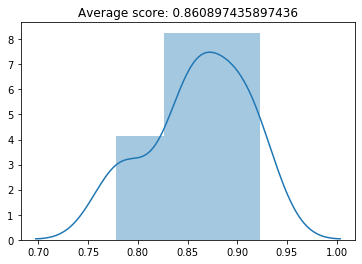

In [64]:
cv_scores = cross_val_score(clf, X, y, cv=10)
print(cv_scores)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

## Saving Classifier

In [102]:
import pickle
pickle.dump(clf, open('GB_model.sav','wb'))

In [103]:
clf = pickle.load(open('GradientBoosting_model.sav','rb'))
arr = np.array([1,1,5,0.1,0.6,1,7])
print(arr.shape)
print("Dysphonic probability:", round(clf.predict_proba([arr])[:,1][0]*100,1),'%')

(7,)
Dysphonic probability: 98.1 %
